In [44]:
from tqdm import tqdm
import os
import twint
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import csv
import math
from math import log2
import matplotlib.pyplot as plt

# Model

In [5]:
matrix = np.load('matrix.npy')
bothMatrix = np.load('bothMatrix.npy')
targetArray = np.load('tagetArray.npy')
topTeamsListMessy = np.load('topTeamsList.npy')

def cleanTeamsList(teamsList):
    cleanList = []
    for user in teamsList:
        cleanUser = user[2:-3]
        cleanList.append(cleanUser)
    return cleanList

topTeamsList = cleanTeamsList(topTeamsListMessy)


In [6]:
from sklearn.naive_bayes import BernoulliNB

def evaluate(target, prediction):
    zipped = zip(target, prediction)
    FP = 0
    TP = 0
    FN = 0
    TN = 0
    for ans, pred in zipped:
        #print(ans, pred)
        if ans < pred:
            FP += 1
        elif ans > pred:
            FN += 1
        elif ans == 0:
            TP += 1
        elif ans == 1:
            TN += 1
        else:
            #print("error")
            pass
            
    return TP, TN, FP, FN


def train(trainingMatrix, trainingTargetArray, testMatrix, testTargetArray):
    model = BernoulliNB()
    model.fit(trainingMatrix, trainingTargetArray)

    prediction = model.predict(testMatrix)

    return evaluate(testTargetArray, prediction)

#evaluate(targetArray, matrix)

In [7]:
trainX = matrix[25:-25]
trainY = targetArray[25:-25]
testX = np.concatenate((matrix[:25], matrix[-25:]), axis = 0)
testY = np.concatenate((targetArray[:25], targetArray[-25:]), axis = 0)

In [8]:
TP, TN, FP, FN = train(trainX, trainY, testX, testY)

In [9]:
accuracy = 1 - ((FP+FN) / (TP+TN+FP+FN))
print(accuracy)

0.6799999999999999


# Entropies

In [10]:
def createSubgroups(matrix, targetArray, teamsList, teamSpec):
    listOfTeam = []
    listOfNotTeam = []
    teamTargetArray = []
    notTeamTargetArray = []
    
    for index, team in enumerate(teamsList):
        if team == teamSpec:
            teamIndex = index
    for index2, person in enumerate(matrix):
        if person[teamIndex] == 1:
            listOfTeam.append(person)
            if int(targetArray[index2]) == 1:
                teamTargetArray.append(1)
            else:
                teamTargetArray.append(0)
        else:
            listOfNotTeam.append(person)
            if int(targetArray[index2]) == 1:
                notTeamTargetArray.append(1)
            else:
                notTeamTargetArray.append(0)
    return listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray

listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeamsList, 'KamalaHarris')

print("KAMALAHARRIS")
print("Length of team matrix: ", len(listOfTeam))
print("Length of NOT team matrix: ", len(listOfNotTeam))


KAMALAHARRIS
Length of team matrix:  130
Length of NOT team matrix:  312


In [11]:
def findTrumpBiden(group, targetArray):
    countTrump = 0
    countBiden = 0
    for index, person in enumerate(group):
        if targetArray[index] == 1:
            countTrump += 1
        else:
            countBiden += 1
    return countTrump, countBiden
countTrump, countBiden = findTrumpBiden(listOfTeam, teamTargetArray)
print("POTUS Biden: ", countBiden)
print("POTUS Trump: ", countTrump)

POTUS Biden:  101
POTUS Trump:  29


In [12]:
def shannonEntropy(vector):

    listOfElements = []
    for p in vector:
        if p > 0:
            element = p*log2(p)
            listOfElements.append(element)
        else:
            element = 0
            listOfElements.append(element)
        entropy = -1 * sum(listOfElements)
    return entropy

In [30]:
def findShannonEntropy(groupTeam, teamTargetArray, matrix):
    countTrumpTeam, countBidenTeam = findTrumpBiden(groupTeam, teamTargetArray)
    if (countTrumpTeam + countBidenTeam) != 0:
        probTrumpTeam = countTrumpTeam / (countTrumpTeam + countBidenTeam)
        probBidenTeam = countBidenTeam / (countTrumpTeam + countBidenTeam)
    else:
        probTrumpTeam = 0
        probBidenTeam = 0

    probTeamVector = [probTrumpTeam, probBidenTeam]
    sEntropy = shannonEntropy(probTeamVector)
    return sEntropy

In [13]:
def findWeightedShannonEntropy(groupTeam, teamTargetArray, matrix):
    countTrumpTeam, countBidenTeam = findTrumpBiden(groupTeam, teamTargetArray)
    if (countTrumpTeam + countBidenTeam) != 0:
        probTrumpTeam = countTrumpTeam / (countTrumpTeam + countBidenTeam)
        probBidenTeam = countBidenTeam / (countTrumpTeam + countBidenTeam)
    else:
        probTrumpTeam = 0
        probBidenTeam = 0

    probTeamVector = [probTrumpTeam, probBidenTeam]
    sEntropy = shannonEntropy(probTeamVector)
    wae = sEntropy * (len(groupTeam)/len(matrix))
    return wae

waeTeam = findWeightedShannonEntropy(listOfTeam, teamTargetArray, matrix)
waeNotTeam = findWeightedShannonEntropy(listOfNotTeam, notTeamTargetArray, matrix)
print("Weighted Average Entropy of team of POTUS User: ", waeTeam)
print("Weighted Average Entropy of NOT team of POTUS User:", waeNotTeam)

Weighted Average Entropy of team of POTUS User:  0.22521947302504128
Weighted Average Entropy of NOT team of POTUS User: 0.6666899774749303


In [14]:
def getSplitWAE(groupTeam, groupNotTeam, teamTargetArray, notTeamTargetArray, matrix):
        wae1 = findWeightedShannonEntropy(groupTeam, teamTargetArray, matrix)
        
        wae2 = findWeightedShannonEntropy(groupNotTeam, notTeamTargetArray, matrix)

        return (wae1 + wae2)

10 Lowest Entropies:  [('KamalaHarris', 0.8919094504999716), ('BarackObama', 0.9469477457556994), ('ArianaGrande', 0.9529453112140598), ('SidneyPowell1', 0.9546119031023518), ('MichelleObama', 0.958975521722012), ('rihanna', 0.9647668343235515), ('NICKIMINAJ', 0.9660898111710107), ('KylieJenner', 0.9695709730344851), ('TrumpWarRoom', 0.9705844310763023), ('kayleighmcenany', 0.9718664627470197)]
10 Highest Entropies:  [('ABC', 0.9992670226986101), ('espn', 0.9992670226986101), ('Twitter', 0.9990524568763821), ('jimmyfallon', 0.9990509447928101), ('NatGeo', 0.99904579377482), ('StephenAtHome', 0.99904579377482), ('SportsCenter', 0.99904579377482), ('DrBiden', 0.9987279314906236), ('BillGates', 0.9983180476184748), ('NFL', 0.9982796895058352)]


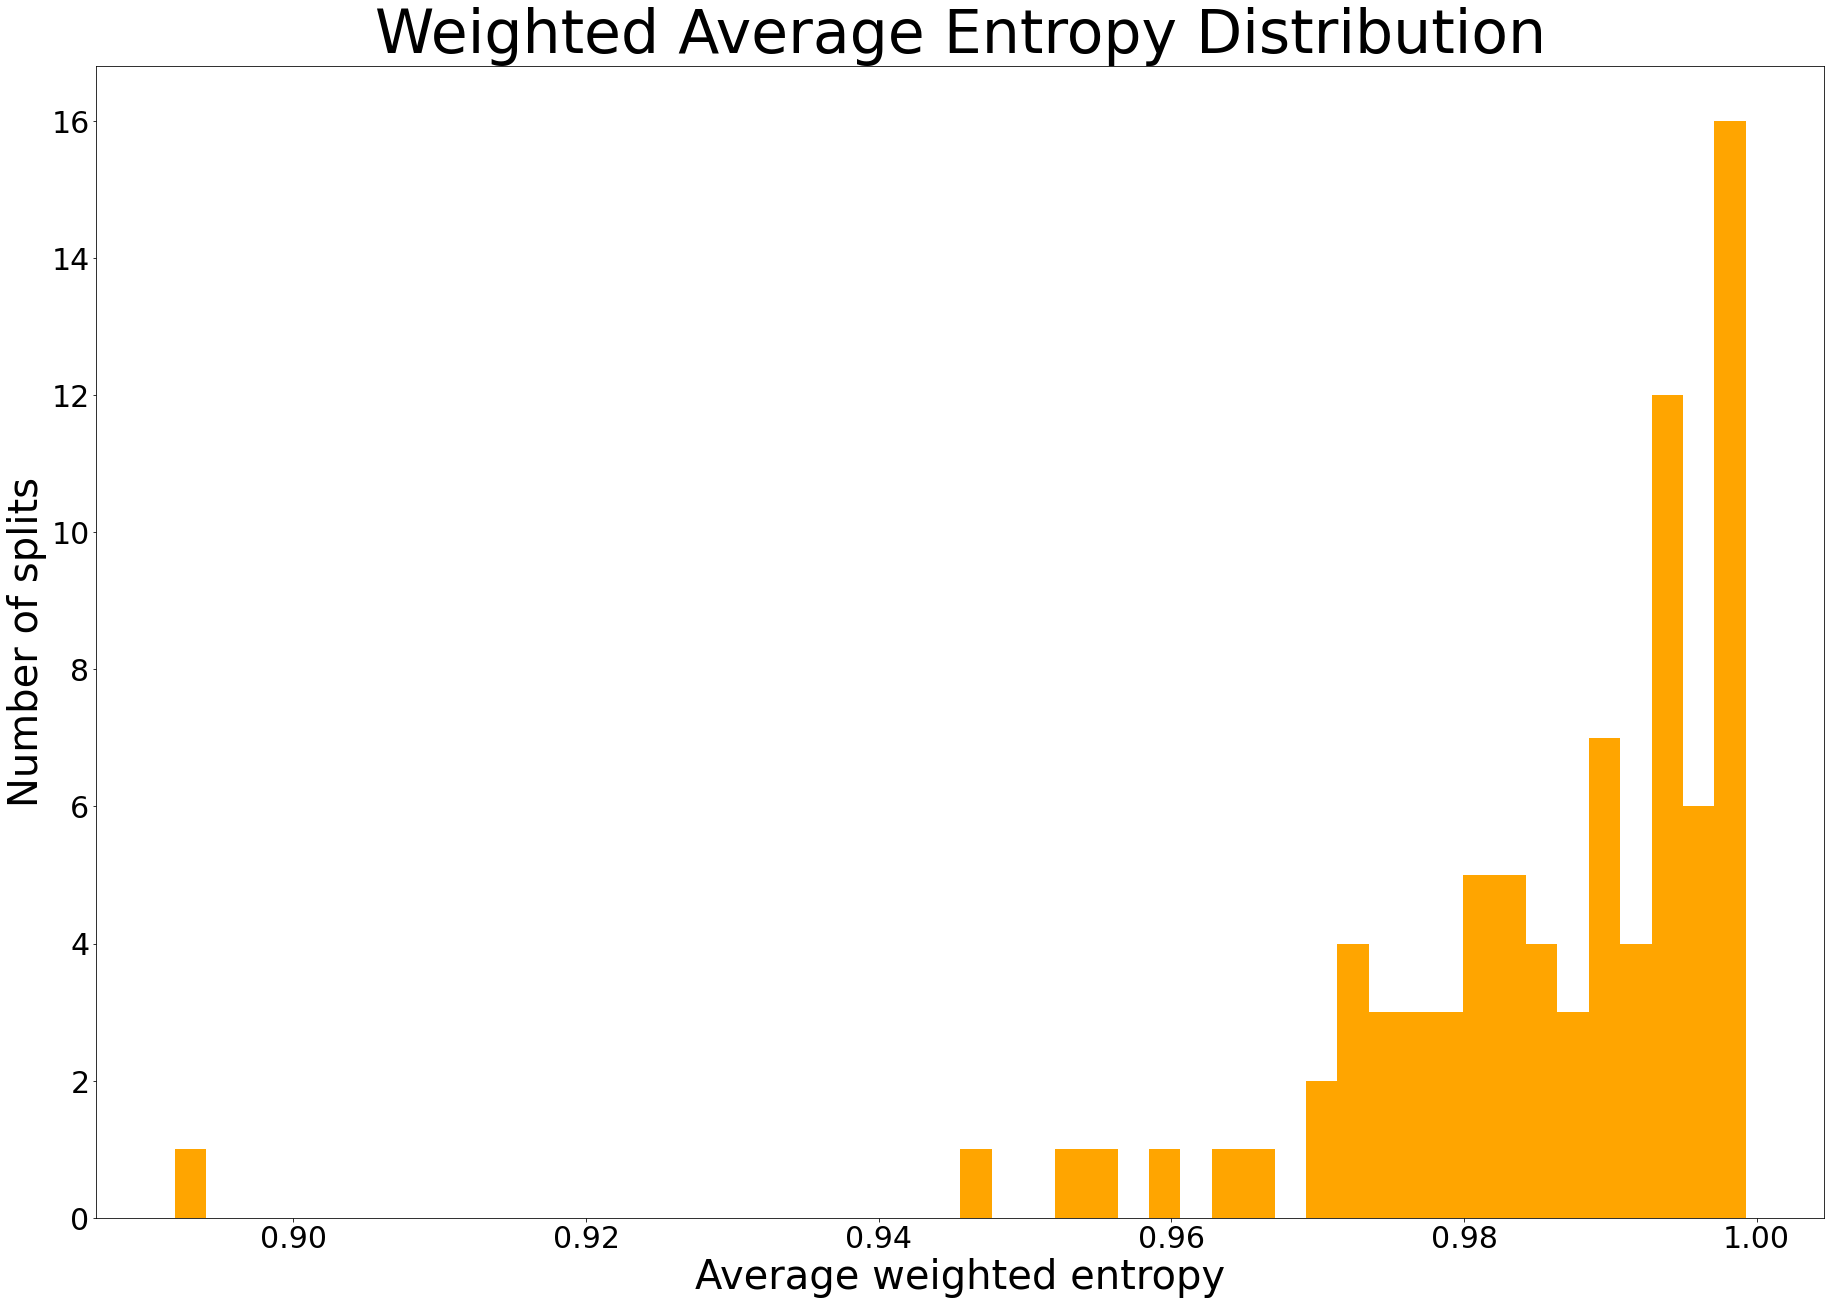

In [92]:
def createWAEDict(matrix, targetArray, topTeams):
    dictWAE = defaultdict(float)
    for index, team in enumerate(topTeams):
        groupTeam, groupNotTeam, TeamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeams, team)
        teamWAE = getSplitWAE(groupTeam, groupNotTeam, TeamTargetArray, notTeamTargetArray, matrix)
        dictWAE[team] = teamWAE
    return dictWAE

dictOfwae = createWAEDict(matrix, targetArray, topTeamsList)
counterWAE = Counter(dictOfwae)

fig, ax1 = plt.subplots()
ax1.hist(counterWAE.values(), color='orange', bins = 50)
ax1.set_title('Weighted Average Entropy Distribution', fontsize=60)
ax1.set_xlabel('Average weighted entropy', fontsize=40)
ax1.set_ylabel('Number of splits', fontsize=40)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
fig.subplots_adjust(left=0, right=4, bottom=0, top=4)

print("10 Lowest Entropies: ", counterWAE.most_common()[:-10-1:-1])
print("10 Highest Entropies: ", counterWAE.most_common(10))

In [93]:
def findLowestSplit(dictOfWAE, matrix, topTeams, targetArray):
    sortedDict = sorted(dictOfWAE.items(), key = lambda x: x[1], reverse = False)
    return sortedDict[0][0]
team = findLowestSplit(newDict, matrix, topTeamsList, targetArray)
print("Lowest entropy: ")
print(team)

Lowest entropy: 
KamalaHarris


In [94]:
def createTree(matrix, topTeams, targetArray):
    if len(matrix) < 5:
        return ""
    waeDict = createWAEDict(matrix, targetArray, topTeams)
    user = findLowestSplit(waeDict, matrix, topTeams, targetArray)
    if user != None:
        group1, group2, targetArray1, targetArray2 = createSubgroups(matrix, targetArray, topTeams, user)
    else:
        return ""
    print()
    print("Split by: ", user)
    print("Weighted entropy: ", waeDict[user])

    group1sEntropy = findShannonEntropy(group1, targetArray1, matrix)
    group2sEntropy = findShannonEntropy(group2, targetArray2, matrix)
    
    if group1sEntropy >= group2sEntropy:
        chaoticGroup = group1
        chaoticTA = targetArray1
        calmGroup = group2
        chaoticEntropy = group1sEntropy
        calmEntropy = group2sEntropy
    else:
        chaoticGroup = group2
        chaoticTA = targetArray2
        calmGroup = group1
        calmEntropy = group1sEntropy
        chaoticEntropy = group2sEntropy

    print("Chaotic group size: ", np.array(chaoticGroup).shape)
    print("Chaotic group entropy: ", chaoticEntropy)
    print("Calm group size: ", np.array(calmGroup).shape)
    print("Calm group entropy: ", calmEntropy)

    return createTree(chaoticGroup, topTeams, chaoticTA)
        

createTree(matrix, topTeamsList, targetArray)

    
    


Split by:  KamalaHarris
Weighted entropy:  0.8919094504999716
Chaotic group size:  (312, 84)
Chaotic group entropy:  0.9444774680894845
Calm group size:  (130, 84)
Calm group entropy:  0.7657462082851403

Split by:  ArianaGrande
Weighted entropy:  0.8978935697462439
Chaotic group size:  (288, 84)
Chaotic group entropy:  0.9111942950464766
Calm group size:  (24, 84)
Calm group entropy:  0.7382848661434506

Split by:  MichelleObama
Weighted entropy:  0.8715800100828932
Chaotic group size:  (275, 84)
Chaotic group entropy:  0.8835020886292702
Calm group size:  (13, 84)
Calm group entropy:  0.6193821946787638

Split by:  DonaldJTrumpJr
Weighted entropy:  0.8461128866074614
Chaotic group size:  (256, 84)
Chaotic group entropy:  0.9089103274103589
Calm group size:  (19, 84)
Calm group entropy:  -0.0

Split by:  whoisaddison
Weighted entropy:  0.8633097917268996
Chaotic group size:  (249, 84)
Chaotic group entropy:  0.8875795449079771
Calm group size:  (7, 84)
Calm group entropy:  -0.0

Spli

''

[[1. 0.]]
[[1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]


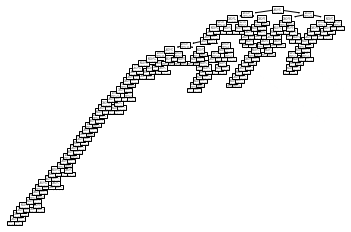

In [99]:
from sklearn import tree
import graphviz

clf = tree.DecisionTreeClassifier()
clf.fit(matrix, targetArray)

x = clf.predict_proba(bothMatrix[0].reshape(1, -1))
print(x)
print(bothMatrix)

tree.plot_tree(clf)
dot_data = tree.export_graphviz(clf, out_file='decisionTree')
graph = graphviz.Source(dot_data)